In [1]:
import sys
import os

# Get the root directory of the project
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the system path
sys.path.insert(0, project_root)
"loaded"

'loaded'

In [2]:
import pandas as pd 
import os
import json

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

import seaborn as sns
sns.set_theme()

In [3]:
from explainable_dataset import *
from viz_utils import create_highlighted_passage
from IPython.display import display, HTML


def highlight_passage(tokens, binary_list):
    highlighted_passage = create_highlighted_passage(tokens,
                                                     binary_list,
                                                     None,
                                                     'green',
                                                     'linear')
    display(HTML("\n".join(highlighted_passage)))
    
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')


In [4]:
file_path = '../data/extracted_relevancy_outs/ms-marco-human-explained/out_1_explained.jsonl'
dataset_1 = ExplanationsDataset(file_path, tokenizer, decode_positive_as_list=True,
                                psg_key='passage', q_key='query')

file_path = '../data/extracted_relevancy_outs/ms-marco-human-explained/out_2_explained.jsonl'
dataset_2 = ExplanationsDataset(file_path, tokenizer, decode_positive_as_list=True  ,                  
                                psg_key='passage', q_key='query')

file_path = '../data/extracted_relevancy_outs/ms-marco-human-explained/out_4_explained.jsonl'
dataset_3 = ExplanationsDataset(file_path, tokenizer, decode_positive_as_list=True  ,                        
                                psg_key='passage', q_key='query')

In [5]:

for i in range(len(dataset_3)):
    dataset_3[i]


In [6]:

dataset_paths = {
    '1_explained': 'extracted_relevancy_outs/ms-marco-human-explained/out_1_explained.jsonl',
    '2_explained': 'extracted_relevancy_outs/ms-marco-human-explained/out_2_explained.jsonl',
    '3_explained': 'extracted_relevancy_outs/ms-marco-human-explained/out_4_explained.jsonl',
    'gemma-2-27b': 'extracted_relevancy_outs/qrels.dev.small/google~gemma-2-27b-it_from0-to6980-one-added-by-hand.jsonl'
}

datasets = {}
for dataset_name, dataset_path_r in dataset_paths.items():
    dataset_path = "../data/" + dataset_path_r
    psg_key = 'passage' if 'explained' in dataset_name else 'psg_text'
    q_key = 'query' if 'explained' in dataset_name else 'q_text'
    d = ExplanationsDataset(dataset_path, tokenizer, decode_positive_as_list=True,error_on_invalid=True,
                                psg_key=psg_key, q_key=q_key)
    datasets[dataset_name] = d

datasets

{'1_explained': <explainable_dataset.ExplanationsDataset at 0x7f7686d81f40>,
 '2_explained': <explainable_dataset.ExplanationsDataset at 0x7f77f419ba90>,
 '3_explained': <explainable_dataset.ExplanationsDataset at 0x7f7686d81cd0>,
 'gemma-2-27b': <explainable_dataset.ExplanationsDataset at 0x7f7686d81dc0>}

In [7]:
datasets['2_explained'][0].keys()

dict_keys(['query', 'passage', 'tokenized_positive', 'tokenized_positive_decoded', 'rationales', 'selected_spans'])

In [8]:
first_queries = [s['query'] for s in datasets['2_explained']]
shared_queries = [{'query': s['query'],'passage': s['passage']}
                  for s in datasets['3_explained'] if s['query'] in first_queries]

print(len(shared_queries))
shared_queries

20


[{'query': 'where are bacteria found?',
  'passage': 'Coliform Bacteria. Coliform bacteria live in soil or vegetation and in the gastrointestinal tract of animals. Coliforms enter water supplies from the direct disposal of waste into streams or lakes, or from runoff from wooded areas, pastures, feedlots, septic tanks, and sewage plants into streams or groundwater.'},
 {'query': 'what to do for bloating and gas',
  'passage': '1 1. What to Do for Gas and Bloating. 2  2. Learn What Causes Intestinal Gas. 3  3. Stop Swallowing Air. 4  4. Take a Look at What You Are Eating. 5  5. Watch What You Drink. 6  6. Try an Over-the-Counter Product. 7  7. Try Probiotics. 8  8. If Applicable, Treat Constipation. 9  9. Put Things in Perspective.'},
 {'query': 'what is the purpose of genetically modified crops? brainly',
  'passage': 'More detail on some of the traits crops are genetically modified to achieve and how they are beneficial to farming is included below: 1  Insect resistance. 2  Drought res

In [9]:
shared_data = []
for d in shared_queries:
    q = d['query']
    p = d['passage']
    cols = {'query': q}
    for d_name, d in datasets.items():
        q_key = d.q_key
        psg_key = d.psg_key
        # print(q_key)
        for s in range(len(d)):      
            try: 
                sample = d[s]
                if sample[q_key] == q and sample[psg_key] == p:
                    dataset_data = {f"{d_name}_{k}": v for k, v in sample.items()}
                    cols.update(dataset_data)
            except AssertionError:
                continue
    shared_data.append(cols)

print(shared_data[1].keys())

dict_keys(['query', '1_explained_query', '1_explained_passage', '1_explained_tokenized_positive', '1_explained_tokenized_positive_decoded', '1_explained_rationales', '1_explained_selected_spans', '2_explained_query', '2_explained_passage', '2_explained_tokenized_positive', '2_explained_tokenized_positive_decoded', '2_explained_rationales', '2_explained_selected_spans', '3_explained_query', '3_explained_passage', '3_explained_tokenized_positive', '3_explained_tokenized_positive_decoded', '3_explained_rationales', '3_explained_selected_spans', 'gemma-2-27b_q_text', 'gemma-2-27b_psg_text', 'gemma-2-27b_tokenized_positive', 'gemma-2-27b_tokenized_positive_decoded', 'gemma-2-27b_rationales', 'gemma-2-27b_selected_spans'])


## Examples of different annotations

In [10]:


gemma_skip = sum([0 if 'gemma-2-27b_tokenized_positive' in data_dict.keys() else 1
             for data_dict in shared_data  ])
print(f"will skip {gemma_skip} data for gemma")

# Iterate through the data
for d in shared_data:
    print(d["query"])
    for annotator_id in dataset_paths.keys():
        print(f"Annottator {annotator_id}")
        
        try:
            highlight_passage(d[f'{annotator_id}_tokenized_positive_decoded'],
                              d[f'{annotator_id}_rationales']
                             )
        except KeyError as e:

            continue
        
    
    print("\n\n")

will skip 0 data for gemma
where are bacteria found?
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





what to do for bloating and gas
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





what is the purpose of genetically modified crops? brainly
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





what is endocrinology clinic
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





pineapple conure price
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





lewiston idaho fedex express phone number
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





balloon meaning
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





how long does it take for opiates to clear from urine
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





artist who painted the famous thanksgiving pic
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





delta airlines cncellation fee
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





distance phoenix to nogales
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





how many of grams a sugar should a person have in one day?
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





how much is unemployment benefits massachusetts
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





is US passport number SSN?
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





what is eye contact solution
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





can you absorb metals from plants
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





what is the weaving machine called
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





causes stomach bloating women
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





when did vhs tape come out
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b





who composed the return of ulysses
Annottator 1_explained


Annottator 2_explained


Annottator 3_explained


Annottator gemma-2-27b


## Inter-agreement annotators <-> annotators; annotators <-> gemma 

In [11]:
df = pd.DataFrame(shared_data)

rationals_by_annotator =  {}

for ann_id in dataset_paths.keys():
    name = f'{ann_id}_rationales'
    xss = df[name].tolist()
    # print(f'{ann_id}_rationales')
    # for x in xss:
    #     print(f"{ann_id} -- {type(x)}")
    x = torch.cat(xss)
    rationals_by_annotator[name] = x

[len(x) for x in rationals_by_annotator.values()]


[1799, 1799, 1799, 1799]

In [12]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

def compute_fleiss_kappa(data):
    data = list(data.values())
    
    # Stack into shape (n_annotators, n_items)
    annot_matrix = torch.stack(data).int().numpy().T  # shape: (n_annotators, n_items)
    
    # Transpose to shape (n_items, n_annotators)
    ratings, category_names = aggregate_raters(annot_matrix)
    return fleiss_kappa(ratings)


only_annotators_data = {k: v for k, v in rationals_by_annotator.items() if 'explained' in k}
print(len(only_annotators_data))
print(len(rationals_by_annotator))

print(f"Fleiss' Kappa annotators only: {compute_fleiss_kappa(only_annotators_data):.3f}")
print(f"Fleiss' Kappa all: {compute_fleiss_kappa(rationals_by_annotator):.3f}")


3
4
Fleiss' Kappa annotators only: 0.431
Fleiss' Kappa all: 0.445


4


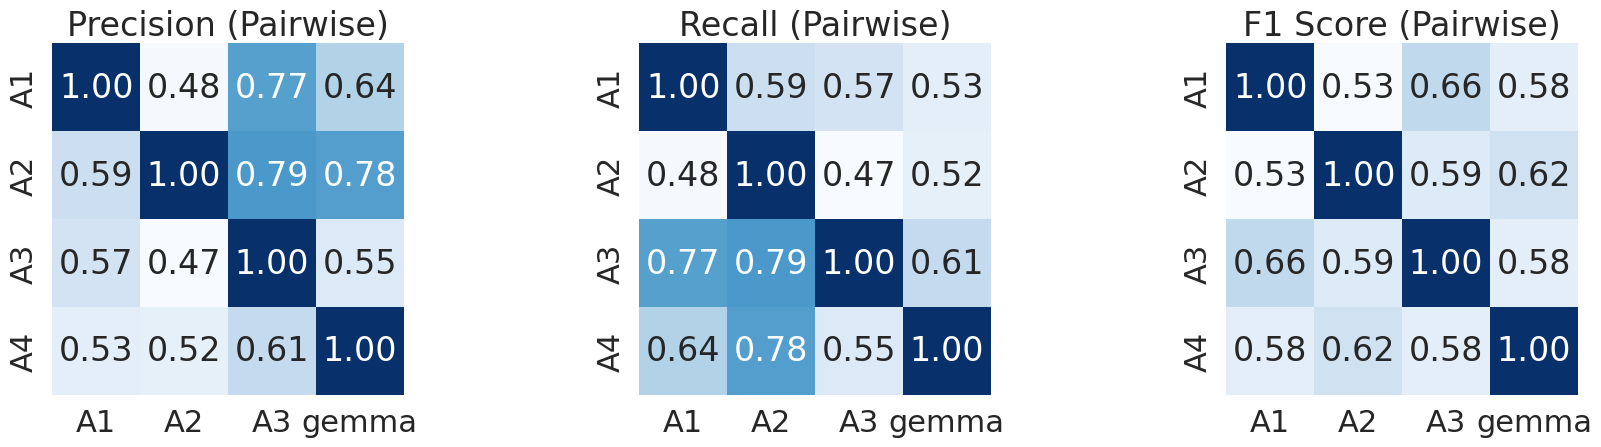

In [21]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import Image, display

# Your list of annotator tensors
annotators = {annotator_name: a.numpy() for annotator_name, a in rationals_by_annotator.items()}
annotators_keys, annotators_values = zip(*annotators.items())

annotators_keys = [
    f"A{a[0]}" if 'explained' in a else 'gemma'
    for a in annotators_keys
]

n = len(annotators)
print(n)

# Initialize empty matrices
precision_matrix = np.ones((n, n))
recall_matrix = np.ones((n, n))
f1_matrix = np.ones((n, n))

# Compute pairwise metrics (upper triangle only, since symmetric)
for i in range(n):
    for j in range(n):
        y_true = annotators_values[i]
        y_pred = annotators_values[j]
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # fill both [i,j] and [j,i] for symmetry
        precision_matrix[i, j] = precision
        recall_matrix[i, j] = recall
        f1_matrix[i, j] = f1

# Plot triangular heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Precision', 'Recall', 'F1 Score']
matrices = [precision_matrix, recall_matrix, f1_matrix]

for ax, matrix, title in zip(axes, matrices, titles):
    sns.heatmap(matrix, # mask=np.tril(np.ones_like(matrix, dtype=bool), k=-1), 
                annot=True, fmt=".2f", cmap="Blues", ax=ax, square=True,
                cbar=False, xticklabels=[f"{annotators_keys[i]}" for i in range(n)],
                yticklabels=[f"A{i+1}" for i in range(n)])
    ax.set_title(f"{title} (Pairwise)")


sns.set_context("notebook", font_scale=2)
plt.tight_layout()
plt.savefig("fig/pairwise-inter-aggrement.pdf", dpi=900, bbox_inches='tight')
plt.show()

## Match between ALL annotators and GEMMA

In [14]:
from collections import defaultdict
import jsonlines

dataset_paths = {
    'out_all_explained': 'extracted_relevancy_outs/ms-marco-human-explained/out_all_explained.jsonl',
    'gemma-2-27b': 'extracted_relevancy_outs/qrels.dev.small/google~gemma-2-27b-it_from0-to6980-one-added-by-hand.jsonl'
}


human_annotated = set()
with jsonlines.open('../data/' + dataset_paths['out_all_explained']) as reader:
    for sample in reader:
        sample_key = (sample['q_id'], sample['psg_id'])
        human_annotated.add(sample_key)

gemma_data = {}
with jsonlines.open('../data/' + dataset_paths['gemma-2-27b']) as reader:
    for sample in reader:
        sample_key = (sample['q_id'], sample['psg_id'])
        gemma_data[sample_key] = sample


found = 0
not_found = set()
for key in human_annotated:
    if key in gemma_data:
        found += 1
    else:
        not_found.add(key)

# print(not_found)

datasets = {}
for dataset_name, dataset_path_r in dataset_paths.items():
    dataset_path = "../data/" + dataset_path_r
    psg_key = 'passage' if 'explained' in dataset_name else 'psg_text'
    q_key = 'query' if 'explained' in dataset_name else 'q_text'
    d = ExplanationsDataset(dataset_path, tokenizer, decode_positive_as_list=True, error_on_invalid=True,
                                psg_key=psg_key, q_key=q_key)
    datasets[dataset_name] = d


both_data = defaultdict(dict)
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    
    for i in range(len(dataset)):
        try: 
            sample = dataset[i]            
            q_key = dataset.q_key
            psg_key = dataset.psg_key
            
            sample_key = (sample[q_key], sample[psg_key])
                
            if dataset_name == 'out_all_explained':
                human_annotated.add(sample_key)
            else:
                if sample_key not in human_annotated:
                    continue
            both_data[dataset_name][sample_key] = sample['rationales']
        except AssertionError:
            # print("lol")
            continue

# Order flattened_data['out_all_explained'] according to flattened_data['gemma-2-27b']
order = list(both_data['gemma-2-27b'].keys())
both_data['out_all_explained'] = {k: both_data['out_all_explained'][k] for k in order}

for v in both_data.values():
    print(type(v))

flattened_data = {k: list(v.values()) for k, v in both_data.items()}
flattened_data = {k: torch.cat(v).numpy().astype(float) for k, v in flattened_data.items()}

print(flattened_data['gemma-2-27b'][:20])
print(flattened_data['out_all_explained'][:20])

print([len(v) for v in list(flattened_data.values())])

out_all_explained
gemma-2-27b
<class 'dict'>
<class 'dict'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[11241, 11241]


In [15]:

def compute_stats(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

compute_stats(flattened_data['gemma-2-27b'], flattened_data['out_all_explained'])


Precision: 0.5741, Recall: 0.6935, F1 Score: 0.6282


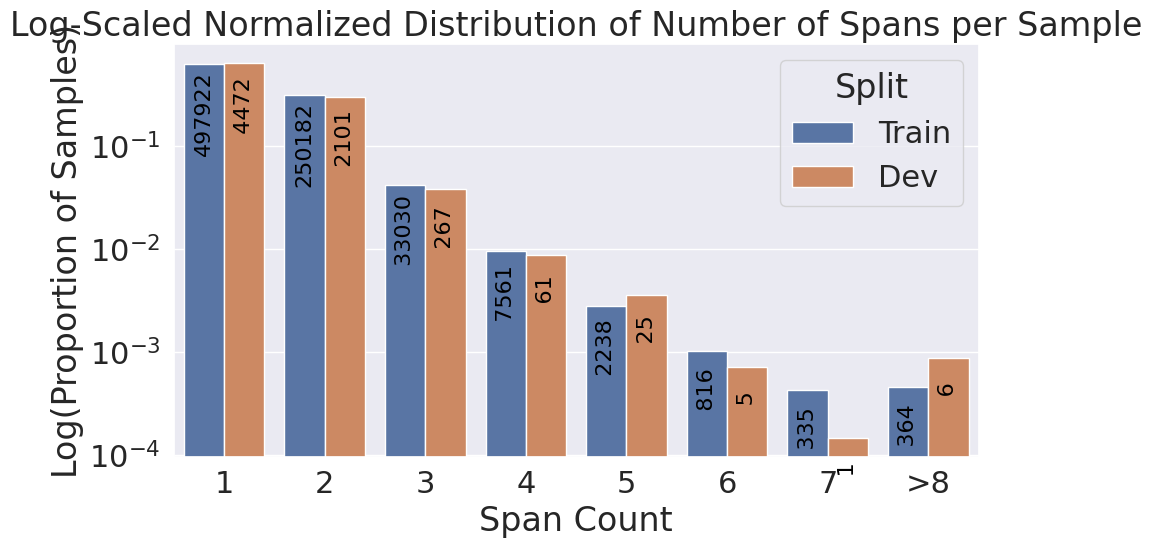

In [46]:
# Compute midpoints based on x-tick positions and bar groupings
span_positions = list(range(len(df['Span Count'])))
offsets = {'Train': -0.2, 'Dev': 0.2}

# Recreate plot with cleaner label positioning
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_norm_long, x='Span Count', y='Proportion', hue='Split')
plt.yscale('log')
plt.title('Log-Scaled Normalized Distribution of Number of Spans per Sample')
plt.ylabel('Log(Proportion of Samples)')
plt.xlabel('Span Count')

# Add count labels exactly at center of each bar
for i, row in df_long.iterrows():
    span_idx = df['Span Count'].tolist().index(row['Span Count'])
    x_pos = span_idx + offsets[row['Split']]
    y_val = df_norm_long.loc[i, 'Proportion']
    label = f"{row['Samples']:>6}"  # right-aligned fixed-width 6
    ax.text(x_pos, y_val / 3, label, ha='center', va='center', fontsize=16, rotation=90, color='black')

plt.tight_layout()
plt.savefig("fig/span-count-histogram.pdf", dpi=900, bbox_inches='tight')
plt.show()
